The data used in this notebook were processed with ClassRunOCNClimoMaker.csh and CMIP6OCNClimoMaker.csh
If you want additional variables that were not processed, you can run that script to get them

This script has been verified to run with the NPL 2024a environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xesmf as xe

from matplotlib.axes import Axes
from matplotlib.patches import Polygon
from cartopy.mpl.geoaxes import GeoAxes

In [2]:
student = ["CMIP6","aydenvdb","CMIP6","rnbarr1","nwharton","congdong","ericmei","jaypillai","geraint","lnzhang","adhall","skygale","smheflin"]

# Fully Coupled 
ddir = '/glade/derecho/scratch/bitz/ATMS559HW3classruns/OceanClimos/'

casenames = ["b.e21.B1850.f19_g17.CMIP6-piControl-2deg.001",
            "DoubleCO2",
            "b.e21.BCO2x4.f19_g17.CMIP6-abrupt4xCO2-2deg.001",
            "AlotofCH4",
            "RaiseSolar",
            "LowerSolar",
            "DirtyAir",
            "IcyNA",
            "DarkIce",
            "NoTrees",
            "FlatTibet",
            "FlatAntarctica",
            "FlatRockies"]

# this is what they were meant to be named
prefernames = ["piControl",
            "DoubleCO2",
            "QuadrupleCO2",
            "AlotofCH4",
            "RaiseSolar",
            "LowerSolar",
            "DirtyAir",
            "IcyNA",
            "DarkSeaIce",
            "NoTrees",
            "FlatTibet",
            "FlatTibet-Antarctica",
            "FlatTibet-Antarctica-Rockies"]

In [3]:
# get Gaussian Weights, gw, from any old cam hist file, a bit slow, sorry
gw=xr.open_dataset('/glade/derecho/scratch/bitz/archive/AMIPpiControl/atm/hist/AMIPpiControl.cam.h0.0001-01.nc').gw

# get any old atm field so we can regrid pop data onto it
atm=xr.open_dataset('/glade/derecho/scratch/bitz/archive/AMIPpiControl/atm/hist/AMIPpiControl.cam.h0.0001-01.nc').TREFHT
landfrac=xr.open_dataset('/glade/derecho/scratch/bitz/archive/AMIPpiControl/atm/hist/AMIPpiControl.cam.h0.0001-01.nc').LANDFRAC

# get regions from any old atm field so we can regrid pop data onto it
regions=xr.open_dataset('/glade/derecho/scratch/bitz/archive/piControl/ocn/hist/piControl.pop.h.0001-01.nc').REGION_MASK

def compute_global(da,gw): # multiply by so-called Gaussian weights that oddly enough sum to 2
    globalmean=(da.mean(dim='lon')*gw).sum(dim='lat')/2
    return globalmean

def depthplot(dT,axn,vmin,vmax,title,cmap='coolwarm'):
    #dT['z_t']=dT['z_t']*1e-2
    cb=dT.plot.pcolormesh(x='lat',y='z_t',add_colorbar=False, vmin=vmin, vmax=vmax, ax=axn,cmap=cmap)
    #axn.set_ylim(0,500)
    axn.set_ylabel('Depth [cm]',size=14)
    axn.set_xlabel('Latitude',size=14)
    axn.set_xticks(np.arange(-80, 90, 20))
    axn.set_xticklabels(['80S','60S','40S','20S','Eq','20N','40N','60N','80N'])
    axn.set_xlim(-80,80)  # customize as you desire
    axn.invert_yaxis()
    #legend
    cbar = plt.colorbar(cb)
    cbar.set_label(title,size=14)
    return 

In [4]:
thevar = 'TEMP' # choose from TEMP or SALT unless you make your own climos

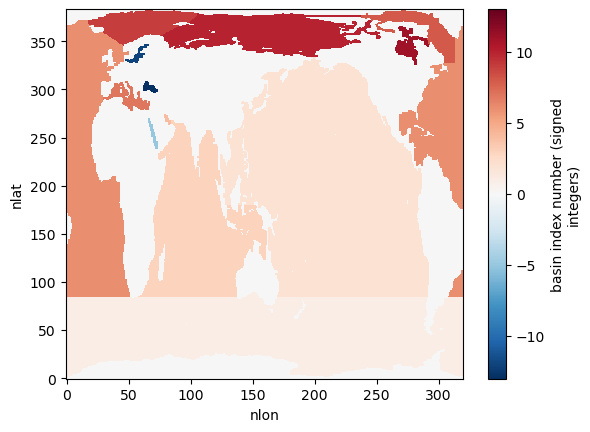

In [5]:
regions.plot() # oh lovely, the POP grid!

In [6]:
# pick out some regions, there are others you could choose
SOmask=regions.where(regions==1,other=np.nan) # Southern Ocean
Pacmask=regions.where(regions==2,other=np.nan)/2. # Pacific
Indmask=regions.where(regions==3,other=np.nan)/3. # Indian
Atlmask=regions.where(regions==6,other=np.nan)/6. # Atlantic

In [8]:
# first get the piControl
casename = casenames[0]
ncfile=ddir+casename+'_'+thevar+'_climo.nc'
cont=xr.open_dataset(ncfile)[thevar]

# get a sample of perturbed data too
casename = casenames[12] # what happens without mountains!
ncfile=ddir+casename+'_'+thevar+'_climo.nc'
pert=xr.open_dataset(ncfile)[thevar]

prefername=prefernames[12]
print("showing results for Response to ",prefername)

pert['time']=cont['time']  # make their time the same, they are both climos so time is kinda meaningless

showing results for Response to  FlatTibet-Antarctica-Rockies


In [9]:
# compute the regrid matrix
# only need to do this once fortunately, could even reuse_weights second time you run script if super impatient

# Regridder doesn't work well with the pop.h data because there are some np.nan over the land points in the lat,lon arrays
# so get data file from cmip6 archive that ncar provided for CESM2 that doesn't have this problem, ignore the warning
ncfile='/glade/work/bitz/cmip6/areacello/areacello_Ofx_CESM2_historical_r1i1p1f1_gn.nc' # th
ds=xr.open_dataset(ncfile)
#ds=cont.isel(z_t=0).isel(time=0) # this didn't work well as just mentioned 
#ds=ds.rename({'TLAT':'lat','TLONG':'lon'}) #  the regridder requires our sample to have lat, lon coordinates
method =  'nearest_s2d'  
regridder = xe.Regridder(ds, atm, method, periodic=False, reuse_weights=False) 
#method = 'bilinear' # this works too 
#regridder = xe.Regridder(ds, atm, method, periodic=True, reuse_weights=False) 

/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Text(0.5, 1.0, 'On CAM Grid')

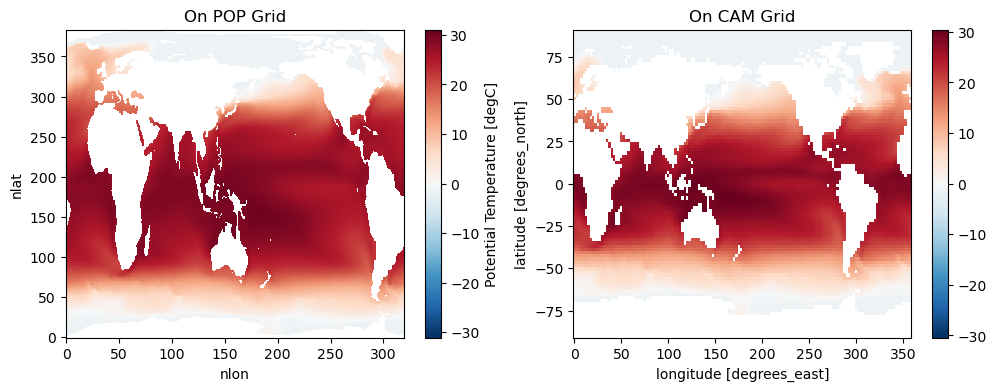

In [10]:
ds=cont.isel(z_t=0).isel(time=0) # get a sample of pop model data 
dsreg = regridder(ds)  # example of applying the regridder on our samp

# demonstrate the regridding of pop model to nice simple cam model grid, note could regrid onto a finer grid if you want, good luck
fig, (ax1, ax2) = plt.subplots( 1, 2, figsize=(12, 4) )
ds.plot(ax=ax1)
ax1.set_title('On POP Grid')
dsreg.plot(ax=ax2)  
ax2.set_title('On CAM Grid')

Text(0.5, 1.0, 'On CAM Grid')

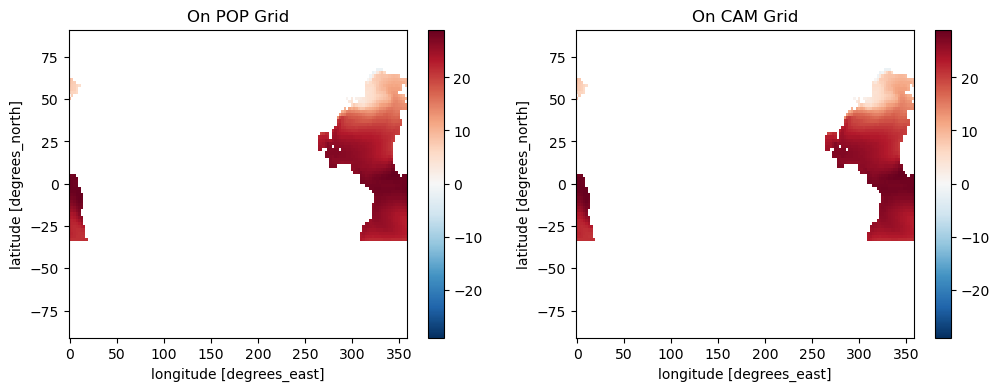

In [11]:
# Atlantic mask on the pop grid
Atlcont=cont*Atlmask
Atlpert=pert*Atlmask

# now regrid, 
Atlcont=regridder(Atlcont) 
Atlpert=regridder(Atlpert) 

# demonstrate the regridding of pop model to nice simple cam model grid, note could regrid onto a finer grid if you want, good luck
fig, (ax1, ax2) = plt.subplots( 1, 2, figsize=(12, 4) )

Atlcont.isel(z_t=0).isel(time=0).plot(ax=ax1)
ax1.set_title('On POP Grid')
# this is how it looks on the CAM grid, it looks okay
Atlcont.isel(z_t=0).isel(time=0).plot(ax=ax2)
ax2.set_title('On CAM Grid')

In [12]:
# repeat in Pac
Paccont=cont*Pacmask
Pacpert=pert*Pacmask
# now regrid, 
Paccont=regridder(Paccont) 
Pacpert=regridder(Pacpert)

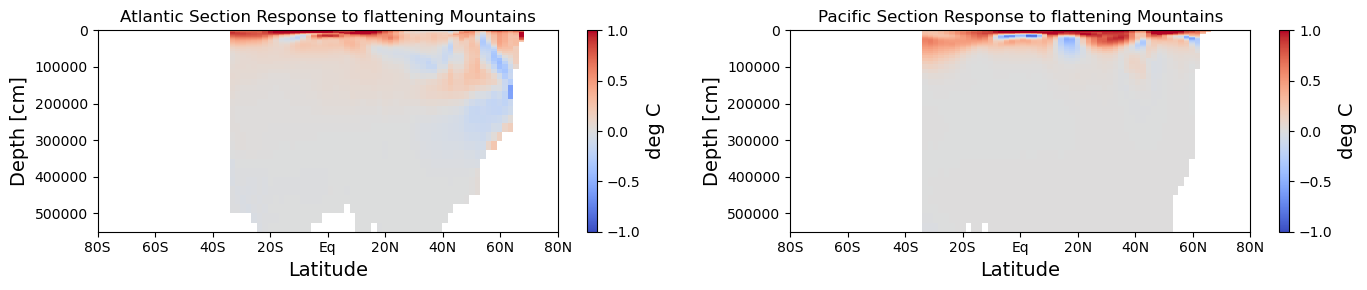

In [13]:
vmax=1 # adjust as needed

fig, axn = plt.subplots(1, 2, figsize=(14, 3))
axn = axn.reshape(-1)

thediff=(Atlpert-Atlcont).mean(dim='time').mean(dim='lon')  # ann mean avg zonally in Atl
depthplot(thediff, axn[0], vmin=-vmax, vmax=vmax, title='deg C')
axn[0].set_title('Atlantic Section Response to flattening Mountains')

thediff=(Pacpert-Paccont).mean(dim='time').mean(dim='lon')  # ann mean avg zonally in Atl
depthplot(thediff, axn[1], vmin=-vmax, vmax=vmax, title='deg C')
axn[1].set_title('Pacific Section Response to flattening Mountains')
fig.tight_layout()


In [17]:
# Repeat more efficiently
casename = casenames[2] 
ncfile=ddir+casename+'_'+thevar+'_climo.nc'
pert=xr.open_dataset(ncfile)[thevar]

prefername=prefernames[2]
print("showing results for Response to ",prefername)

pert['time']=cont['time']  # make their time the same, they are both climos so time is kinda meaningless

# mask on the pop grid
Atlcont=cont*Atlmask
Atlpert=pert*Atlmask
# now regrid, 
Atlcont=regridder(Atlcont) 
Atlpert=regridder(Atlpert)

# repeat in Pac
Paccont=cont*Pacmask 
Pacpert=pert*Pacmask
# now regrid, 
Paccont=regridder(Paccont)
Pacpert=regridder(Pacpert)

showing results for Response to  QuadrupleCO2


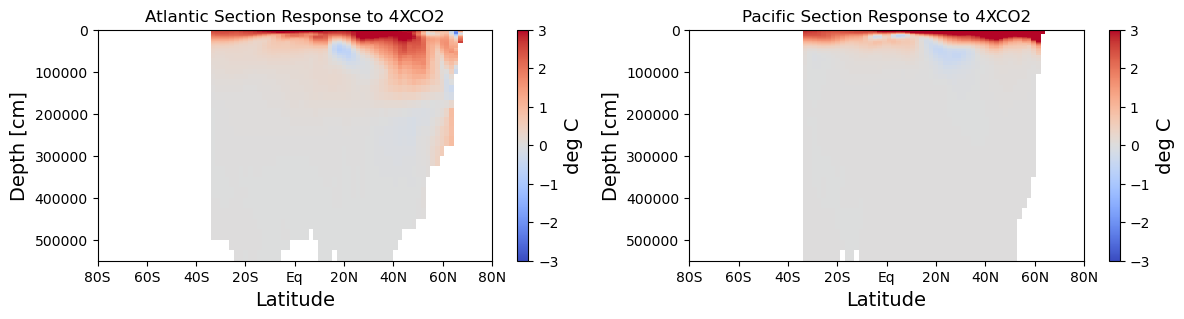

In [18]:
vmax=3 # adjust as needed

ffig, axn = plt.subplots(1, 2, figsize=(14, 3))
axn = axn.reshape(-1)

thediff=(Atlpert-Atlcont).mean(dim='time').mean(dim='lon')  # ann mean avg zonally in Atl
depthplot(thediff, axn[0], vmin=-vmax, vmax=vmax, title='deg C')
axn[0].set_title('Atlantic Section Response to 4XCO2')

thediff=(Pacpert-Paccont).mean(dim='time').mean(dim='lon')  # ann mean avg zonally in Atl
depthplot(thediff, axn[1], vmin=-vmax, vmax=vmax, title='deg C')
axn[1].set_title('Pacific Section Response to 4XCO2')
fig.tight_layout()


# Next we'll plot AMOC and Nothward heat transport (N_HEAT) thankfully these are simpler

In [54]:
thevar = 'N_HEAT'

# first get the piControl
casename = casenames[0]
ncfile=ddir+casename+'_'+thevar+'_climo.nc'
cont=xr.open_dataset(ncfile)[thevar]

# get a sample of perturbed data too
casename = casenames[2] 
ncfile=ddir+casename+'_'+thevar+'_climo.nc'
pert=xr.open_dataset(ncfile)[thevar]

prefername=prefernames[2]
print("showing results for Response to ",prefername)

pert['time']=cont['time']  # make their time the same, they are both climos so time is kinda meaningless

showing results for Response to  QuadrupleCO2


In [55]:
# this is FYI
print(cont.transport_components.values)
print()
print(cont.transport_regions.values)

[b'Total' b'Eulerian-Mean Advection'
 b'Eddy-Induced Advection (bolus) + Diffusion'
 b'Eddy-Induced (bolus) Advection' b'Submeso Advection']

[b'Global Ocean - Marginal Seas'
 b'Atlantic Ocean + Mediterranean Sea + Labrador Sea + GIN Sea + Arctic Ocean + Hudson Bay']


Text(0, 0.5, 'PW')

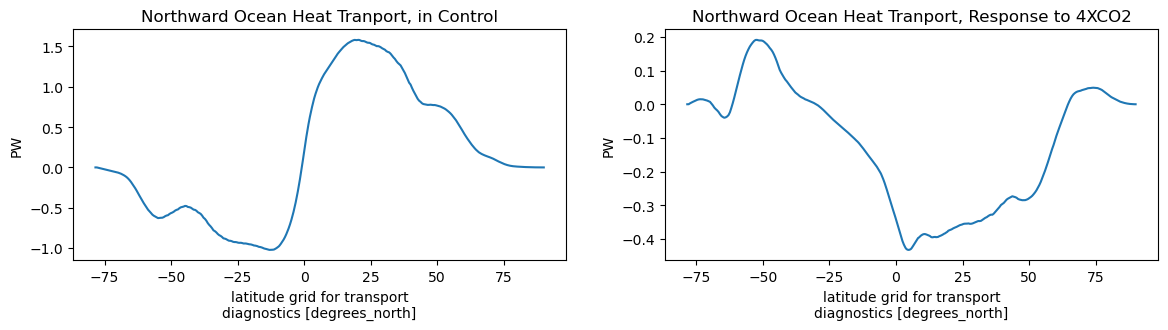

In [56]:
# making life easier we'll just deal with global ocean, total 

ffig, axn = plt.subplots(1, 2, figsize=(14, 3))
axn = axn.reshape(-1)

thecontrol=cont.isel(transport_comp=0).isel(transport_reg=0).mean(dim='time')
thecontrol.plot(ax=axn[0])
axn[0].set_title('Northward Ocean Heat Tranport, in Control')
axn[0].set_ylabel('PW') # that petawatts

thediff=(pert-cont).isel(transport_comp=0).isel(transport_reg=0).mean(dim='time')
thediff.plot(ax=axn[1])
axn[1].set_title('Northward Ocean Heat Tranport, Response to 4XCO2')
fig.tight_layout()
axn[1].set_ylabel('PW') # that petawatts


In [57]:
thevar = 'MOC'

# first get the piControl
casename = casenames[0]
ncfile=ddir+casename+'_'+thevar+'_climo.nc'
cont=xr.open_dataset(ncfile)[thevar]

# get a sample of perturbed data too
casename = casenames[2] 
ncfile=ddir+casename+'_'+thevar+'_climo.nc'
pert=xr.open_dataset(ncfile)[thevar]

prefername=prefernames[2]
print("showing results for Response to ",prefername)

pert['time']=cont['time']  # make their time the same, they are both climos so time is kinda meaningless


showing results for Response to  QuadrupleCO2


In [58]:
# this is FYI
print(cont.moc_components.values)

[b'Eulerian Mean' b'Eddy-Induced (bolus)' b'Submeso']


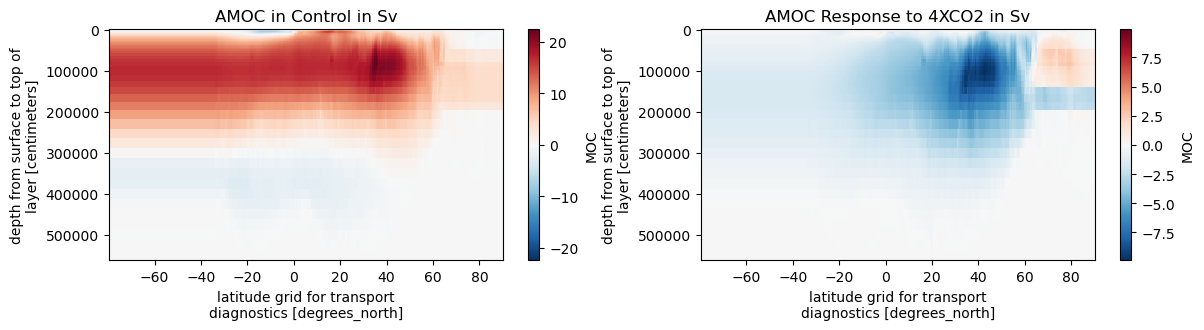

In [60]:
# making life easier we'll just deal with global ocean, total 

ffig, axn = plt.subplots(1, 2, figsize=(14, 3))
axn = axn.reshape(-1)

thecontrol=cont.sum(dim='moc_comp').isel(transport_reg=1).mean(dim='time')
thecontrol.plot(ax=axn[0])
axn[0].invert_yaxis()
axn[0].set_title('AMOC in Control in Sv')

thediff=(pert-cont).sum(dim='moc_comp').isel(transport_reg=1).mean(dim='time')
thediff.plot(ax=axn[1])
axn[1].set_title('AMOC Response to 4XCO2 in Sv')
axn[1].invert_yaxis()

fig.tight_layout()
